## UNet

![Unet Architecture](./Unet_arch.png)

In [1]:
from collections import OrderedDict
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from model import UNet

In [3]:
import numpy as np
from medpy.filter.binary import largest_connected_component
from skimage.exposure import rescale_intensity
from skimage.transform import resize

In [4]:
from glob import glob

train_files = []
mask_files = glob('./dataset/kaggle_3m/*/*_mask.*')

for i in mask_files:
    train_files.append(i.replace('_mask', ''))

In [5]:
import os

In [6]:
rood_dir = './dataset/kaggle_3m/*/'

n_items_per_dir = {}
all_dirs = glob(rood_dir, recursive = True)
for d in all_dirs:
    files = os.listdir(d)
    file_count = len(files) / 2
    if file_count in n_items_per_dir:
        n_items_per_dir[file_count] += 1
    else:
        n_items_per_dir[file_count] = 1

n_items_per_dir

{23.0: 3,
 20.0: 14,
 24.0: 5,
 22.0: 6,
 25.0: 2,
 26.0: 4,
 28.0: 4,
 38.0: 5,
 40.0: 2,
 36.0: 15,
 71.0: 1,
 53.0: 2,
 57.0: 1,
 51.0: 3,
 60.0: 4,
 58.0: 2,
 56.0: 2,
 52.0: 1,
 49.0: 1,
 34.0: 1,
 32.0: 8,
 35.0: 2,
 42.0: 1,
 37.0: 4,
 31.0: 1,
 48.0: 3,
 27.0: 1,
 50.0: 1,
 73.0: 1,
 30.0: 2,
 21.0: 5,
 80.0: 1,
 88.0: 2}

In [7]:
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread

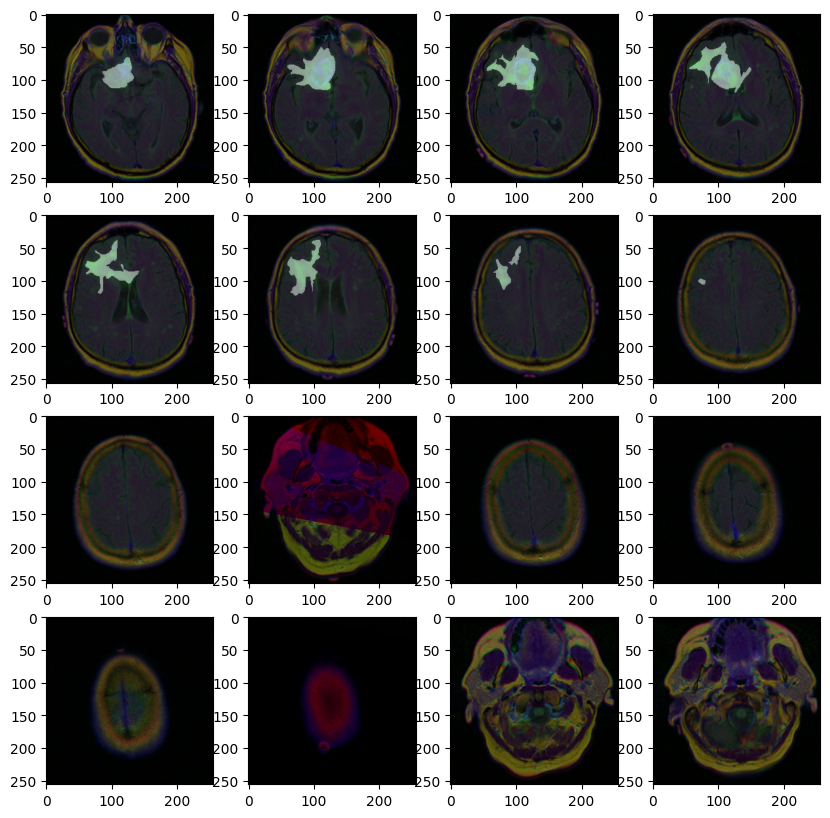

In [8]:
rows, cols = 4,4
fig = plt.figure(figsize=(10,10))

for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    img_path = train_files[i]
    mask_path = mask_files[i]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(mask_path)

    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)

plt.show()

In [9]:
from torch.utils.data import DataLoader
from dataset import BrainSegmentationDataset
from transform import BinarizeMask, transforms

In [10]:
batch_size = 22

def datasets():
    aug_scale = 0.05
    aug_angle = 15
    image_size = 256

    images_dir = './dataset/kaggle_3m'

    train = BrainSegmentationDataset(
        images_dir=images_dir,
        subset="train",
        image_size=image_size,
        random_sampling=False,
        transform=transforms(scale=aug_scale, angle=aug_angle, flip_prob=0.5),
    )

    validation = BrainSegmentationDataset(
        images_dir=images_dir,
        subset="validation",
        image_size=image_size,
        random_sampling=False,
        transform=BinarizeMask()
    )

    return train, validation

def data_loaders():
    dataset_train, dataset_valid = datasets()

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=1,
        worker_init_fn=worker_init,
    )

    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=1,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

In [11]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2 * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [12]:
import os
from medpy.filter.binary import largest_connected_component
from utils import dsc, dsc_per_volume

In [13]:
import torch.optim as optim

In [14]:
epochs = 150
vis_freq = 10
vis_images = 200

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

In [15]:
loader_train, loader_valid = data_loaders()
loaders = {
    "train": loader_valid,
    "valid": loader_valid,
}

reading train images...
preprocessing train volumes...
cropping train volumes...
padding train volumes...
resizing train volumes...
normalizing train volumes...
done creating train dataset
reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


### Training

In [16]:
unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
unet.to(device)

dsc_loss = DiceLoss()
best_validation_dsc = 0.0

optimizer = optim.Adam(unet.parameters(), lr=0.0001)

loss_train = []
loss_valid = []

step = 0

In [17]:
from tqdm import tqdm

In [19]:
for epoch in tqdm(range(epochs), total=epochs):
    for phase in ["train", "valid"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1

            x, y_true = data
            x, y_true = x.to(device), y_true.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                y_pred = unet(x)

                loss = dsc_loss(y_pred, y_true)

                if phase == "valid":
                    loss_valid.append(loss.item())
                    y_pred_np = y_pred.detach().cpu().numpy()
                    validation_pred.extend(
                        [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                    )
                    y_true_np = y_true.detach().cpu().numpy()
                    validation_true.extend(
                        [y_true_np[s] for s in range(y_true_np.shape[0])]
                    )
                    
                if phase == "train":
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()

        if phase == "valid":
            mean_dsc = np.mean(
                dsc_per_volume(
                    validation_pred,
                    validation_true,
                    loaders["valid"].dataset.patient_slice_index,
                )
            )
            
            if mean_dsc > best_validation_dsc:
                best_validation_dsc = mean_dsc
                torch.save(unet.state_dict(), os.path.join('./weights', "unet.pt"))
                print("Best validation mean DSC: {:4f}".format(best_validation_dsc)) 
                
            loss_valid = []      
            

  1%|▊                                                                                                                         | 1/150 [01:22<3:25:21, 82.70s/it]

Best validation mean DSC: 0.377438


  5%|█████▊                                                                                                                      | 7/150 [03:11<34:28, 14.47s/it]

Best validation mean DSC: 0.571119


  9%|███████████▍                                                                                                               | 14/150 [03:43<11:52,  5.24s/it]

Best validation mean DSC: 0.579774


 10%|████████████▎                                                                                                              | 15/150 [03:47<11:10,  4.96s/it]

Best validation mean DSC: 0.737666


 17%|█████████████████████▎                                                                                                     | 26/150 [04:35<08:58,  4.34s/it]

Best validation mean DSC: 0.771281


 20%|████████████████████████▌                                                                                                  | 30/150 [04:52<08:37,  4.31s/it]

Best validation mean DSC: 0.808182


 21%|█████████████████████████▍                                                                                                 | 31/150 [04:57<08:33,  4.32s/it]

Best validation mean DSC: 0.820605


 25%|██████████████████████████████▎                                                                                            | 37/150 [05:23<08:08,  4.33s/it]

Best validation mean DSC: 0.827281


 25%|███████████████████████████████▏                                                                                           | 38/150 [05:27<08:05,  4.33s/it]

Best validation mean DSC: 0.837772


 34%|█████████████████████████████████████████▊                                                                                 | 51/150 [06:23<07:08,  4.32s/it]

Best validation mean DSC: 0.861874


 37%|█████████████████████████████████████████████                                                                              | 55/150 [06:40<06:50,  4.32s/it]

Best validation mean DSC: 0.880398


 49%|███████████████████████████████████████████████████████████▊                                                               | 73/150 [07:58<05:32,  4.32s/it]

Best validation mean DSC: 0.889912


 56%|████████████████████████████████████████████████████████████████████▉                                                      | 84/150 [08:46<04:45,  4.32s/it]

Best validation mean DSC: 0.908151


 65%|████████████████████████████████████████████████████████████████████████████████▎                                          | 98/150 [09:46<03:44,  4.31s/it]

Best validation mean DSC: 0.909173


 66%|█████████████████████████████████████████████████████████████████████████████████▏                                         | 99/150 [09:50<03:40,  4.32s/it]

Best validation mean DSC: 0.909951


 69%|████████████████████████████████████████████████████████████████████████████████████▌                                     | 104/150 [10:12<03:18,  4.32s/it]

Best validation mean DSC: 0.913417


 71%|██████████████████████████████████████████████████████████████████████████████████████▏                                   | 106/150 [10:21<03:10,  4.32s/it]

Best validation mean DSC: 0.913605


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 122/150 [11:30<02:01,  4.33s/it]

Best validation mean DSC: 0.916038


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 126/150 [11:47<01:43,  4.33s/it]

Best validation mean DSC: 0.921443


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 133/150 [12:17<01:13,  4.33s/it]

Best validation mean DSC: 0.931026


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 148/150 [13:22<00:08,  4.31s/it]

Best validation mean DSC: 0.931605


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149/150 [13:26<00:04,  4.33s/it]

Best validation mean DSC: 0.935067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [13:31<00:00,  5.41s/it]
